# Tasks for laboratory assignment 2

In [2]:
# imports section

import pandas as pd
import numpy as np
import string
import json
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize , sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from autocorrect import Speller
import nltk
from wordcloud import WordCloud

import gensim as gs
from gensim.test.utils import lee_corpus_list
from gensim.models import Word2Vec
import gensim.downloader as api
import matplotlib.pyplot as plt

# Download the necessary resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Олександр\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Олександр\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Олександр\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Extract data from the json file 

Write a script, that would extract all the the data from the json file and return it in a list of texts for further use in the next tasks

In [3]:
def extract_texts_from_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return json.load(file)["texts"]
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return []

texts = extract_texts_from_file('resources/data.json')
print(texts)

['Oppenheimer, directed by Christopher Nolan, delves into the life of J. Robert Oppenheimer, the theoretical physicist who led the development of the atomic bomb. The film explores his moral and emotional struggles.', "Oppenheimer captures the life of the 'father of the atomic bomb' and his internal conflict after the success of the Manhattan Project. The film's complex narrative reflects on the cost of scientific achievement.", 'In Oppenheimer, Cillian Murphy delivers a riveting performance as the conflicted physicist who grapples with the consequences of his groundbreaking work on the atomic bomb, under the weight of global politics and ethics.', 'Oppenheimer is a cinematic exploration of ambition, guilt, and responsibility. Through stunning visuals and a thought-provoking story, Nolan brings the life of the brilliant but haunted physicist to the big screen.', 'Ducks are versatile waterfowl, known for their adaptability in freshwater and coastal habitats. With webbed feet and waterpr

## Process the texts

Write a script, that would process these texts. Processing should include:

- Lowercasing
- Removing Punctuation
- Removing Special Characters and Numbers
- Stemming or Lemmatization
- Handling Abbreviations
- Spelling Correction

In [4]:
def process_texts(texts):
    ps = PorterStemmer() 
    spell = Speller()
    stop_words = set(stopwords.words('english'))

    abbreviations = {
        "don't": "do not",
        "won't": "will not",
        "isn't": "is not",
        "i'm": "I am",
        "we'll": "we will",
        "he's": "he is",
        "they're": "they are",
        "there's": "there is",
        "it's": "it is",
        "didn't": "did not",
        "couldn't": "could not",
        "doesn't": "does not",
    }

    processed_texts = []

    for text in texts:
        # 1. Lowercasing
        text = text.lower()
        
        # 2. Remove punctuation, special characters, and numbers
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
        text = re.sub(r'\d+', '', text)  # Remove numbers
        
        # 3. Handle abbreviations
        words = text.split()
        expanded_words = [abbreviations.get(word, word) for word in words]
        text = ' '.join(expanded_words)
        
        # 4. Spell correction
        text = spell(text)
        
        # 5. Tokenize the text
        words =  re.findall(r'\b\w+\b', text)
        #words = nltk.tokenize.word_tokenize(text, language="english", preserve_line=False)
        
        # 6. Remove stopwords
        words = [word for word in words if word not in stop_words]
        
        # 7. Stemming
        words = [ps.stem(word) for word in words]
        
        processed_texts.append(words)

    return processed_texts

texts_processed = process_texts(texts)
print(texts_processed)

[['oppenheim', 'direct', 'christoph', 'nolan', 'elv', 'life', 'j', 'robert', 'oppenheim', 'theoret', 'physicist', 'led', 'develop', 'atom', 'bomb', 'film', 'explor', 'moral', 'emot', 'struggl'], ['oppenheim', 'captur', 'life', 'father', 'atom', 'bomb', 'intern', 'conflict', 'success', 'manhattan', 'project', 'film', 'complex', 'narr', 'reflect', 'cost', 'scientif', 'achiev'], ['oppenheim', 'million', 'murphi', 'deliv', 'rivet', 'perform', 'conflict', 'physicist', 'grape', 'consequ', 'groundbreak', 'work', 'atom', 'bomb', 'weight', 'global', 'polit', 'ethic'], ['oppenheim', 'cinemat', 'explor', 'ambit', 'guilt', 'respons', 'stun', 'visual', 'thoughtprovok', 'stori', 'nolan', 'bring', 'life', 'brilliant', 'haunt', 'physicist', 'big', 'screen'], ['duck', 'versatil', 'waterfowl', 'known', 'adapt', 'freshwat', 'coastal', 'habitat', 'web', 'feet', 'waterproof', 'feather', 'excel', 'swimmer', 'migrat', 'long', 'distanc', 'find', 'food', 'warmer', 'climat'], ['lamp', 'spider', 'talk', 'yesterd

## Visualize as cloud of words

Visualize the texts as a cloud of words.

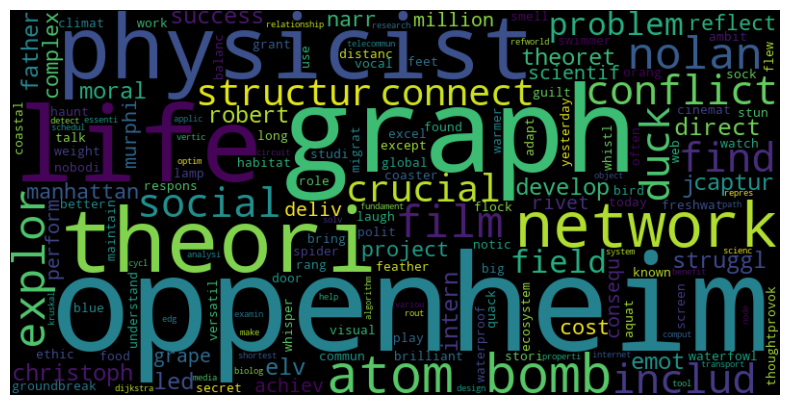

In [5]:
def visualize_texts(texts_processed):
    text_together = " ".join([word for sentence in texts_processed for word in sentence])
    
    wc = WordCloud(width=800,height=400).generate(text_together)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return None

visualize_texts(texts_processed)

## Calculate cosine similarities using TFIDF

Calculate the TFIDF score and cosine similarity between the texts. You may use gensim, write your own script using numpy or use other module. Output the result as a matrix $n\times n$ of cosine similarity scores (where $n$ is the length of texts list).

**Extra credit**: use word2vec word embeddings in vector spaces to get better TFIDF scores by representing each word as a vector.

In [6]:
def calcuate_tfidf(texts_processed):
    sorted_text_list = sorted(set(sum(texts_processed, [])))
    word_to_index  = {k:i for i,k in enumerate(sorted_text_list)}
    term_frequency_matrix  = np.zeros((len(texts_processed), len(sorted_text_list)), dtype=int)

    for i, doc in enumerate(texts_processed):
        for word in doc:
            term_frequency_matrix[i, word_to_index[word]] +=1
    
    inverse_document_frequency  = np.log(term_frequency_matrix.shape[0]/term_frequency_matrix.astype(bool).sum(axis=0))

    tfidf_matrix  = term_frequency_matrix * inverse_document_frequency
    normalized_tfidf_matrix  = tfidf_matrix / np.linalg.norm(tfidf_matrix, axis=1)[:,None]
    transposed_matrix = normalized_tfidf_matrix.T
    cosine_similarity_matrix = normalized_tfidf_matrix @ transposed_matrix

    return cosine_similarity_matrix

cosine_matrix = calcuate_tfidf(texts_processed)
print(cosine_matrix)

[[1.         0.11549759 0.07934248 0.12750824 0.         0.
  0.         0.         0.         0.        ]
 [0.11549759 1.         0.08401093 0.03016259 0.         0.
  0.         0.         0.         0.        ]
 [0.07934248 0.08401093 1.         0.02962464 0.         0.
  0.         0.         0.         0.        ]
 [0.12750824 0.03016259 0.02962464 1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.02510716 0.         0.0279789  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.02510716 0.
  1.         0.02491535 0.02872394 0.02602375]
 [0.         0.         0.         0.         0.         0.
  0.02491535 1.         0.07437807 0.08146322]
 [0.         0.         0.         0.         0.0279789  0.
  0.02872394 0.07437807 1.         0.12291612]
 [0.         0.         0.         0.

## Visualize data

Visualize the `cosine_matrix` data using matplotlib. Choose your own method of plotting the scores in a way, that the similarity indeces between texts would be instantly visible. Plot data about texts as well (a couple of first words in the document).

*Hint: remember heat maps, aren't they nice for this task?*

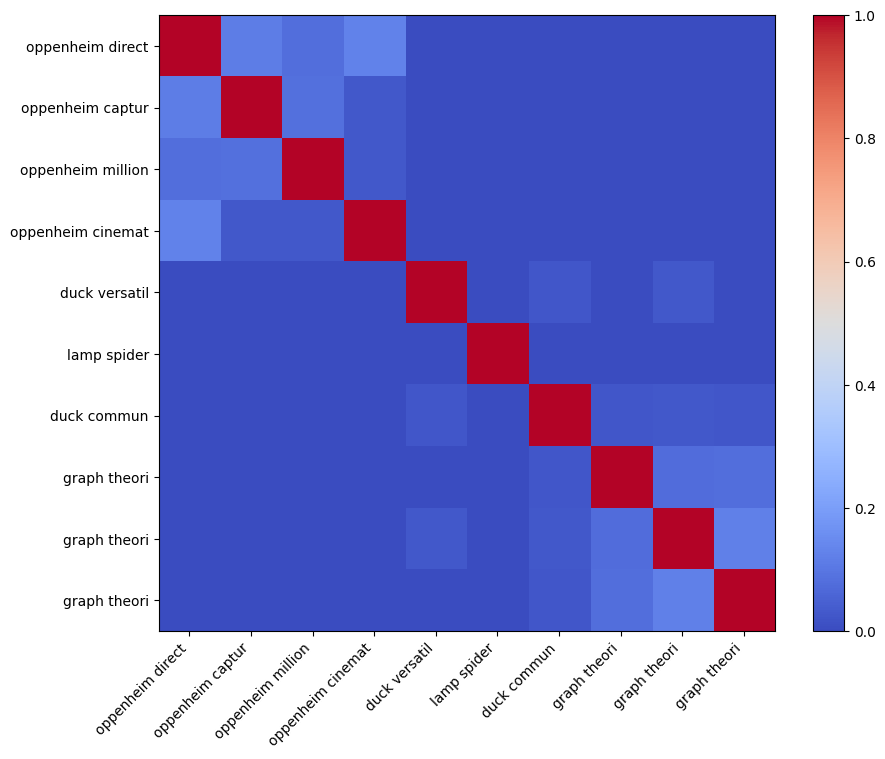

In [7]:
import matplotlib.pyplot as plt
def visualize_data(cosine_matrix, texts_processed):
    labels = [' '.join(text[:2]) for text in texts_processed]
    plt.figure(figsize=(10, 8))
    plt.imshow(cosine_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    plt.show()

visualize_data(cosine_matrix, texts_processed)

## Analyse your own text using TFIDF (or any other method)

Analyse your own text using previous methods. You may use API fetching to get text data, download texts from Kaggle or use any texts you want. Find cosine similarities and visualize them.

Readed file: ['This paddle sport supply store is stocked to the rafters with a staggering selection of everything you could possibly ever need to get your crazy paddle on.  Owners, Jeff and Darren, are friendly and quick to answer even silly newbie questions.', "This place is a veritable candy store for outdoor enthusiasts, especially kayak and canoers. Really friendly and knowledgeable people ready to help. They have a huge inventory of watercraft out back, so don't get fooled by the size of the building or showroom. The building backs up to a channel that makes it possible to test drive a kayak or canoe. One word of warning - you will want to buy something, anything, when you walk in.", "I've done quite a bit of canoeing and kayaking - lakes, rivers, whitewater, but, never actually owned my own Kayak.  I live on the Sugar River and was looking for a nice boat that had a good balance of maneuverability, stability, tracking, and efficiency so I could use it on the river but, also take 

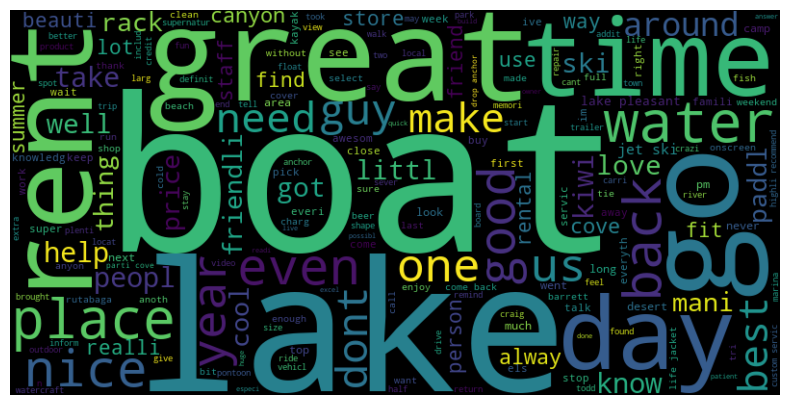

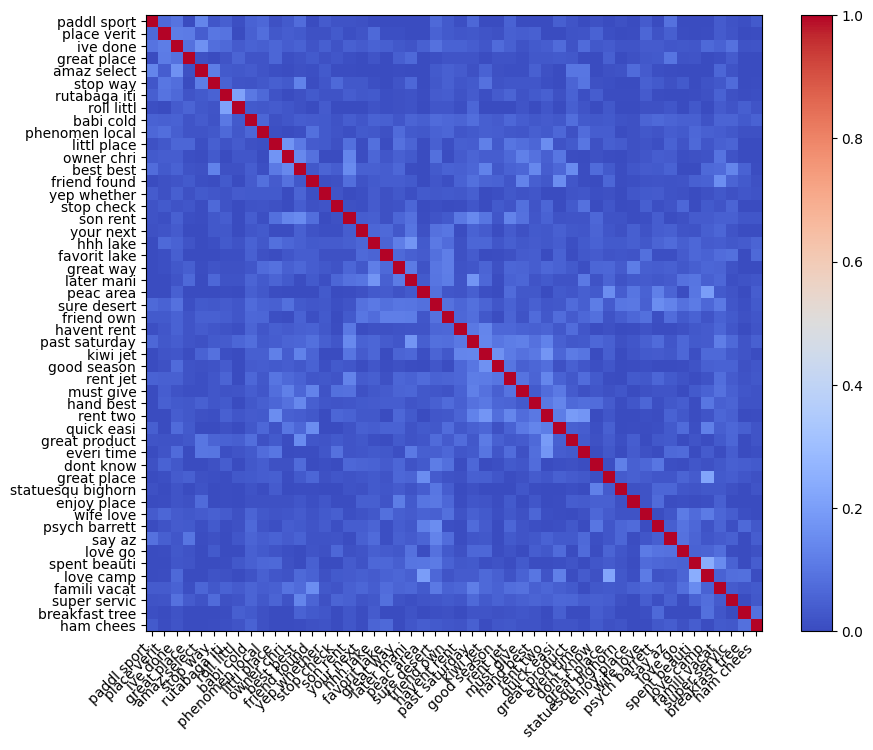

In [8]:
def get_texts():
   with open('resources/TrainingDataPositive.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
    lines = [line.strip() for line in lines]
    return lines

texts = get_texts()
print("Readed file: " + str(texts))
texts_processed = process_texts(texts)
visualize_texts(texts_processed)
cosine_matrix = calcuate_tfidf(texts_processed)
visualize_data(cosine_matrix, texts_processed)